# full model

All the stuff needed to get a cleanliness score!

## import stuff

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, math, yelp_query
import pickle as pkl
agg_model_directory = r'data/models/aggregate_model/'
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# NLP
import gensim.downloader
from gensim import matutils
from spacy.lang.en.stop_words import STOP_WORDS
STOP_WORDS = STOP_WORDS.union({'ll', 've','s','id'})

# language detection
from langdetect import DetectorFactory
DetectorFactory.seed = 0
from langdetect import detect, detect_langs

In [2]:
%%time
# import GloVe word vectors (twitter dataset, 200 dimensions)
gv = gensim.downloader.load('glove-twitter-200')

CPU times: total: 1min 32s
Wall time: 1min 32s


In [3]:
# these are a few representative words
DIRTY_WORDS = ('disgusting','smelly','rotten','nasty','gross','dirty','undercooked','moldy','puke','sick','unhealthy')
PEST_WORDS = ('rat','bugs','cockroach','fly','ant','flea','insect','infestation','infest')
# average vector of these words
DIRTY_VECTOR = np.mean(np.array([gv[w] for w in DIRTY_WORDS]),axis=0)
PEST_VECTOR = np.mean(np.array([gv[w] for w in PEST_WORDS]),axis=0)

## feature engineering

In [4]:
# DON'T stem/lemmatize here because the glove_vectors vocabulary doesn't do that
def text_cleaner(s):
    s = re.sub('<[^<]+?>', '', s.lower()) # remove tags
    # remove stop words
    s = re.sub('[^a-z\s\n]', '', s)
    s = s.split()
    # spacy stop words are a little more complete than gsp stop words
    s = [w for w in s if not w in STOP_WORDS]
    return s

In [151]:
def apply_gv(doc, method='list'):
    """
        Grabs glove of each word of the review
        Returns a list of vectors
    """
    vecs = []
    keys = []
    for w in doc:
        if w in ('food','like'): # words that hurt us!
            continue
        try:
            vec = gv[w]
        except KeyError: # if glove doesn't have a vector
            continue
        vecs.append(vec)
        keys.append(w)
    if vecs: 
        vecs = np.asarray(vecs)
        return vecs
    if not vecs:
        return None

In [152]:
def vec_similarity(vec1, vec2):
    """
        Dot product of two unit vectors to get similarity between them, same implementation as gensim similarity
    """
    return np.dot(matutils.unitvec(vec1),matutils.unitvec(vec2))

In [153]:
def review2vec(text):
    """
        Cleans text, vectorizes words, measures cosine distance to selected DIRTY_WORDS and PEST_WORDS, and calculates aggregate features.
        Output is a dataframe of one row
    """
    vecs = apply_gv(text_cleaner(text), 'list')
    
    # corner case: all words are not in the vocabulary (i.e., different language, short reviews, typo-ridden reviews, etc.)
    if vecs is None:
        return pd.DataFrame([np.nan]) # still return something so we keep the indexing

    # dataframe for each review
    df = pd.DataFrame()
    df['vec'] = list(vecs)
    df['dirty_sim'] = df.vec.apply(lambda v: vec_similarity(DIRTY_VECTOR, v))
    df['pest_sim'] = df.vec.apply(lambda v: vec_similarity(PEST_VECTOR, v))
    df['both_sim'] = df[['dirty_sim','pest_sim']].max(axis=1)

    # average all word vectors to make a review vector
    df_agg = pd.DataFrame([np.mean(df.vec)])
    df_agg['both_sim'] = np.mean(df.both_sim)
    df_agg['pest_sim'] = np.mean(df.pest_sim)
    df_agg['dirty_sim'] = np.mean(df.dirty_sim)
    df_agg.columns = df_agg.columns.astype(str)
    return df_agg

In [57]:
def filter_reviews(review_list):
    """
        Removes reviews if they are < 10 words long or not in English
    """
    rl = pd.DataFrame({'text': review_list})
    # rl = rl[rl.text.apply(len) >= 10]
    rl['language'] = rl['text'].apply(detect)
    return rl[rl.language == 'en'].text.values

In [58]:
def review_list_2vec(review_list):
    """
        Applies review2vec to a list of reviews
    """
    review_list = filter_reviews(review_list)
    return pd.concat(map(review2vec, review_list)).reset_index(drop=True)

### test it out

In [59]:
bad_reviews = [r"This place was absolutely disgusting. We considered turning around as soon as we walked in as it had an odd vibe, unpleasant smell and almost no customers. BUT I've been to my fair share of decent dive type spots so we decided we'd stick around and give it a chance. The sweet tea was great, but all of the food was inedible. Clearly frozen calamari tasted like fried rubber bands with several of the pieces looking questionable and moldy. The fried catfish looked like cafeteria/hospital food. It too was obviously just frozen (freezer burned) catfish they threw in the fryer along with kindergarten crinkle fries and crunchy hush puppies. I honestly couldn't even eat my food both because it was gross and in fear of getting sick. I forced myself to throw up as soon as I got home and I wish I was kidding. The worst part is that the bill was $40 for two entrees and and appetizer which is absolutely insane considering the quality of what they put in front of us. I wish I'd gone to Long John Silvers on my way in the parking lot instead. I absolutely do not recommend this place whatsoever.",
               r"Horrible service, dirty facility; I gave them 2 stars because the catfish nuggets were pretty good and the wine was cold. When asking for the check; our server asked my husband to write down everything we ordered so he could create a receipt; I'm still confused by this because no one else at our table had to do that. Weird anyway; I'll never go back there.",
               r"We came on a Friday evening and parking lot was full so it seemed promising however we were clearly mistaken. The dining room is fairly small and we were able to snag a table by the entrance. The table had not wiped down so there was still water rings and food crumbs from the previous person. We wiped down the table ourselves and waited for our server. 10 mins later no one came by the table. No one even looked in our direction. Was this a walk up to the bar and order yourself place? Who knows. There was what appeared to be a waitress offering menus to other tables. We left without even having anything so we can't comment on the food but unfortunately we won't be returning.",
               r"Literally the most disgusting restaurant experience I've ever had. First of all our server did NOT wear a mask. She was rude as hell and downright didn't even know the menu. The food that came out was over cooked flounder that we didn't even eat. Actually spit the food into my napkin. Wouldn't wish this place on my worst enemy.",
               r"Let me start w ordering. I ordered online. Got to the place to pick up my food then bam... my order wasn't ready. They couldn't even find my order. They thought I placed it for another location. Had to show from my phone I placed to round rock location. The guy had to call someone to get my online order. Had to wait an extra 30 min. Place was crowded and big groups of families in there. The food was ok. I wasn't that impressed. I got it to go bc I don't eat in restaurants due to Covid. So by the time I made it home it tasted old. Kind of stale. Like the grease the food was fried in was not fresh. Can't say I'll be back",
               r"Expected more. Seemed dingy. Not very clean overall. Service was not up to par. They seemed to be more focus on serving those at the bar then at the tables. Our table was dirty, sticky. Menu was disgusting to the touch. The food was okay. Will not go again.",
               r"Oysters on the half were good, kinda hard to mess them up. Wife ordered broiled rainbow trout, the fish was spoiled! You could smell it once the waitress set it on the table, so either their cook has no sense of smell or they just dont care if they make someone sick. The wait staff spends more time at the bar playing on their phones than they do waiting on customers. They did wear mask but there was no social distance between tables or at the bar. Speaking of the bar, it's very loud to the point you cannot have a conversation at your table. We will definitely never go back to this place and I would not recommend it anyone else  either.",
               r"They failed health inspection with a score of 37 on December 10th, 2019. Report stated too many cockroaches to count and had rat feces in the dish area",
               r"I came here on Friday night with my family for dinner, this place is severely understaffed. And for that reason I can't find it in me to come back. All the waitstaff is running around stressing out and it shows in the quality of the food and service. It look 10 min to get greeted and welcomed, we ordered a app which came out after the food. My boyfriend ordered the crawfish that had a awful taste and smell, I ordered a shrimp salad which came with brown slimy lettuce a half of a slice of tomato and ranch dressing for 12.99 the menu said it was supposed to include more veggies so i asked for the side i was brought that and then noticed how old the lettuce was. My sisters crab cakes tasted old and no flavor whatsoever. My son ordered the chicken tenders and fries as my 2 year old is eating his food we notice a long hair inside of his food we then decided to take our complaints to the manger which told us that they are understaffed and extremely busy..... I really hope the owner of this establishment can do what needs to be done to get this place in the right track. I'm giving 2 starts for potential but I won't be back... your better off going to razzoos down the street"
              ]

In [60]:
review_list_2vec(bad_reviews)

,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,both_sim,pest_sim,dirty_sim
0,-0.122761,-0.140523,0.013761,0.126739,-0.016212,0.129047,0.685494,-0.020908,-0.081969,-0.081777,...,0.046690,0.196057,-0.038282,0.038551,0.218165,-0.028024,0.062944,0.424231,0.302000,0.421592
1,-0.032505,0.050436,-0.169728,-0.017089,-0.037259,-0.103373,0.653337,-0.052908,-0.080635,-0.154353,...,-0.045164,0.138027,-0.029336,-0.005300,0.095929,-0.007832,-0.112733,0.420371,0.289804,0.409951
2,-0.009950,-0.062636,0.072052,-0.022103,0.066415,0.028064,0.690810,0.054007,-0.141170,0.020800,...,-0.090386,0.230739,-0.087393,0.045911,0.172093,0.102420,-0.096463,0.366196,0.290885,0.357787
3,-0.071920,0.093048,0.053545,0.099249,-0.050880,0.066754,0.734152,0.006229,-0.067743,0.101473,...,-0.041406,0.161426,0.017293,0.064277,0.259017,0.014467,-0.018924,0.456650,0.342566,0.444006
4,-0.140540,0.055006,-0.003033,0.051524,0.022536,0.111972,0.629624,-0.006311,0.032565,-0.017267,...,-0.024619,0.098146,-0.126267,-0.008171,0.082553,0.068570,0.030551,0.394826,0.308460,0.388349
5,-0.057482,-0.211958,-0.026156,0.133579,0.091525,0.055019,0.476415,-0.216702,-0.180483,-0.036918,...,-0.074740,0.140040,-0.093231,0.055606,0.096667,0.010448,-0.086859,0.375417,0.247398,0.372709
6,-0.147599,-0.088799,0.103643,0.047378,-0.015356,0.095968,0.582954,-0.024950,-0.071377,-0.052517,...,-0.031760,0.111573,0.046286,-0.001087,0.164747,0.022014,-0.040487,0.402959,0.308322,0.388843
7,-0.010421,-0.059542,-0.041128,-0.089066,0.032596,0.095098,0.381393,0.020560,-0.027078,-0.056732,...,-0.112557,-0.022826,-0.098082,-0.142926,-0.021019,0.173555,0.110392,0.347074,0.317385,0.309704
8,-0.190099,-0.075647,0.016191,0.115216,0.017390,0.106435,0.638685,-0.056439,-0.127406,-0.175251,...,0.128045,0.080168,-0.093835,0.070920,0.212744,0.031652,0.044607,0.398466,0.298654,0.395888


## aggregate model

In [183]:
def agg_features(review_features):
    """
        Takes as input the output of review_list_2vec()
    """
    dff = pd.DataFrame(review_features.mean(axis=0)).T
    # dff['num_reviews'] = len(review_features)
    return dff

In [3]:
model = pkl.load(open(agg_model_directory + 'mean_vectors_agg_model.pkl', 'rb'))
# model = pkl.load(open(agg_model_directory + 'mean_vectors_agg_model_ridge.pkl', 'rb'))

### test it out

In [292]:
review_features = review_list_2vec(bad_reviews)
features = agg_features(review_features)
model.predict(features)

array([85.52950088])

In [293]:
review_list_2vec(bad_reviews)

,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,both_sim,pest_sim,dirty_sim
0,-0.122761,-0.140523,0.013761,0.126739,-0.016212,0.129047,0.685494,-0.020908,-0.081969,-0.081777,...,0.046690,0.196057,-0.038282,0.038551,0.218165,-0.028024,0.062944,0.424231,0.302000,0.421592
1,-0.032505,0.050436,-0.169728,-0.017089,-0.037259,-0.103373,0.653337,-0.052908,-0.080635,-0.154353,...,-0.045164,0.138027,-0.029336,-0.005300,0.095929,-0.007832,-0.112733,0.420371,0.289804,0.409951
2,-0.009950,-0.062636,0.072052,-0.022103,0.066415,0.028064,0.690810,0.054007,-0.141170,0.020800,...,-0.090386,0.230739,-0.087393,0.045911,0.172093,0.102420,-0.096463,0.366196,0.290885,0.357787
3,-0.071920,0.093048,0.053545,0.099249,-0.050880,0.066754,0.734152,0.006229,-0.067743,0.101473,...,-0.041406,0.161426,0.017293,0.064277,0.259017,0.014467,-0.018924,0.456650,0.342566,0.444006
4,-0.140540,0.055006,-0.003033,0.051524,0.022536,0.111972,0.629624,-0.006311,0.032565,-0.017267,...,-0.024619,0.098146,-0.126267,-0.008171,0.082553,0.068570,0.030551,0.394826,0.308460,0.388349
5,-0.057482,-0.211958,-0.026156,0.133579,0.091525,0.055019,0.476415,-0.216702,-0.180483,-0.036918,...,-0.074740,0.140040,-0.093231,0.055606,0.096667,0.010448,-0.086859,0.375417,0.247398,0.372709
6,-0.147599,-0.088799,0.103643,0.047378,-0.015356,0.095968,0.582954,-0.024950,-0.071377,-0.052517,...,-0.031760,0.111573,0.046286,-0.001087,0.164747,0.022014,-0.040487,0.402959,0.308322,0.388843
7,-0.010421,-0.059542,-0.041128,-0.089066,0.032596,0.095098,0.381393,0.020560,-0.027078,-0.056732,...,-0.112557,-0.022826,-0.098082,-0.142926,-0.021019,0.173555,0.110392,0.347074,0.317385,0.309704
8,-0.190099,-0.075647,0.016191,0.115216,0.017390,0.106435,0.638685,-0.056439,-0.127406,-0.175251,...,0.128045,0.080168,-0.093835,0.070920,0.212744,0.031652,0.044607,0.398466,0.298654,0.395888


In [294]:
agg_features(review_list_2vec(bad_reviews))

,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,both_sim,pest_sim,dirty_sim
0,-0.087031,-0.048957,0.002127,0.049492,0.012306,0.064998,0.608096,-0.033047,-0.082811,-0.050282,...,-0.027322,0.125928,-0.055872,0.013087,0.142322,0.04303,-0.011886,0.398465,0.300608,0.387648


## add in Yelp API query

In [295]:
business_id, reviews = yelp_query.get_reviews(name = "Super Bowl", address="719 W William Cannon Dr Ste 103")

Business found: Super Bowl


In [296]:
review_features = review_list_2vec(reviews)
features = agg_features(review_features)
model.predict(features)

array([79.90303531])

## additional things to show on the webapp

some visualization ideas for the webapp:
* histogram of review scores
* histogram of word scores
* plot dimensionally reduced word vectors?
* cluster?

In [188]:
business_id, reviews = yelp_query.get_reviews(name = "Super Bowl", address="719 W William Cannon Dr Ste 103")

Business found: Super Bowl


In [297]:
review_features = review_list_2vec(reviews)
features = agg_features(review_features)
model.predict(features)

array([79.90303531])

In [299]:
# worst review using random forest on each review
reviews[np.argmin(model.predict(review_features))]

"Dang, I really, really liked Super Bowl at first! I specifically like their General Tso's chicken and crab rangoons. Online ordering is very convenient, too (though I hate the delivery charge + tip). However, other items are pretty bad. Their soups aren't appetizing and I made the mistake of ordering their fried rice last time. It doesn't even look like typical American fried rice. There are no vegetables, meat, or egg, it just looks like they pan fry the rice with soy sauce. Pretty disappointing. But yeah, I love the entrees and rangoons, but if I want to explore a menu a bit more I think I might just have to turn elsewhere."

In [29]:
# worst review using random forest on each review
reviews[np.argmax(model.predict(review_features))]

NameError: name 'reviews' is not defined

(array([ 1.,  0.,  2.,  4.,  8.,  4.,  9., 14., 10., 18., 14., 12., 10.,
        13., 15.,  9., 11.,  7., 12.,  9., 10.,  5.,  4.,  6.,  2.,  4.,
         4.,  2.,  1.,  1.]),
 array([81.53337114, 81.89982967, 82.2662882 , 82.63274674, 82.99920527,
        83.3656638 , 83.73212233, 84.09858086, 84.46503939, 84.83149792,
        85.19795645, 85.56441498, 85.93087351, 86.29733205, 86.66379058,
        87.03024911, 87.39670764, 87.76316617, 88.1296247 , 88.49608323,
        88.86254176, 89.22900029, 89.59545883, 89.96191736, 90.32837589,
        90.69483442, 91.06129295, 91.42775148, 91.79421001, 92.16066854,
        92.52712707]),
 <BarContainer object of 30 artists>)

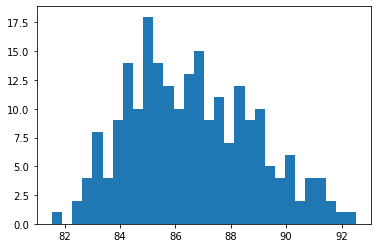

In [301]:
plt.hist(model.predict(review_features),bins=30)

In [303]:
# worst review using mean GLOVE
reviews[np.argmax(review_features.both_sim)]

'The food is decent depending on the day you order. If you get delivery. They never get your order right, unfortunately. Always pick up or dine in. Stay away from delivery!'

(array([ 1.,  0.,  2.,  3.,  1.,  6., 12., 18., 21., 31., 30., 41., 23.,
        16.,  5.,  7.,  1.,  2.,  0.,  1.]),
 array([0.2766794 , 0.2874663 , 0.29825321, 0.30904012, 0.31982703,
        0.33061393, 0.34140084, 0.35218775, 0.36297466, 0.37376156,
        0.38454847, 0.39533538, 0.40612229, 0.41690919, 0.4276961 ,
        0.43848301, 0.44926991, 0.46005682, 0.47084373, 0.48163064,
        0.49241754]),
 <BarContainer object of 20 artists>)

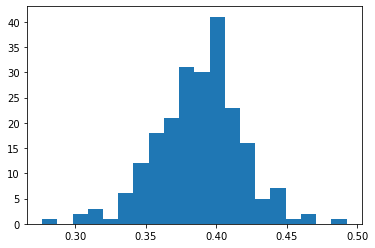

In [304]:
plt.hist(review_features.both_sim,bins=20)

## compare to all values

In [2]:
df = pd.read_csv('data/models/review_model/mean_vectors_full_df.csv.gz',compression='gzip').dropna()
df = df.drop(df.columns[0],axis=1)

### histogram of predicted values

In [4]:
%%time
drop_columns = ['business_id', 'review_id', 'text', 'date', 'Score','stars', 'language']
groups = df.sort_values('both_sim',ascending=False).groupby('business_id')
df_list = []
for business_id, group in groups:
    dff = pd.DataFrame()
    # average ALL reviews from each business
    ll = len(group)
    # bound = math.ceil(ll*0.15)
    dff[business_id] = group.drop(drop_columns,axis=1).mean(axis=0)
    dff=dff.T
    dff['num_reviews'] = ll
    # dff['percent_bad_reviews'] = sum(group.review_stars <= 2) / ll
    dff['Score'] = group.Score.unique().mean()
    df_list.append(dff)
df_tot = pd.concat(df_list)

CPU times: total: 4.67 s
Wall time: 4.67 s


In [5]:
%%time
X = df_tot.drop(['Score','num_reviews','review_stars'],axis=1)
y = df_tot.Score.values

X_shuff, y_shuff = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_shuff, y_shuff, test_size=0.2, random_state=42)

CPU times: total: 15.6 ms
Wall time: 6 ms


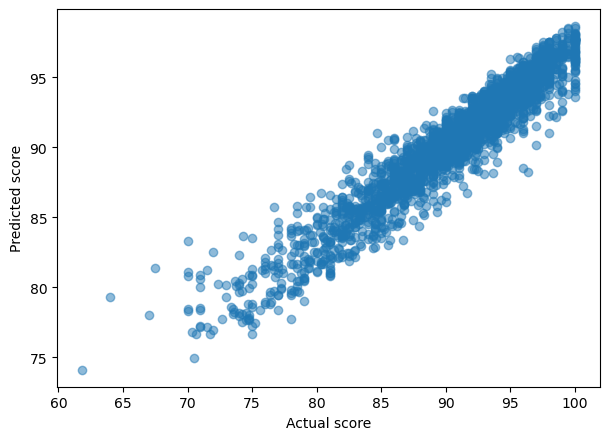

In [6]:
y_predict = model.predict(X)
fig = plt.figure(figsize=(7,5),dpi=100)
plt.scatter(y, y_predict, alpha=0.5)
plt.xlabel('Actual score')
plt.ylabel('Predicted score')
# plt.legend(['Actual score','Predicted score'])
plt.show()

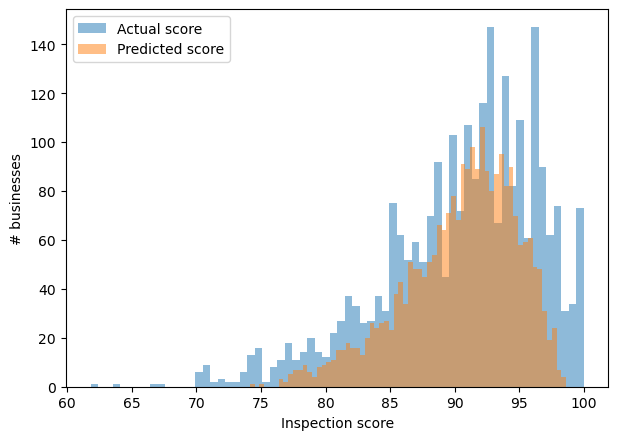

In [7]:
y_predict = model.predict(X)
fig = plt.figure(figsize=(7,5),dpi=100)
plt.hist(y,bins=66,alpha=0.5)
plt.hist(y_predict,bins=66,alpha=0.5)
plt.xlabel('Inspection score')
plt.ylabel('# businesses')
plt.legend(['Actual score','Predicted score'])
plt.show()

In [10]:
np.savetxt('data/processed data/predicted_business_insp_scores.csv', y_predict, delimiter=',')

### histogram of both_sims

In [11]:
business_both_sims = df.groupby('business_id').agg(both_sim = ('both_sim','mean')).values

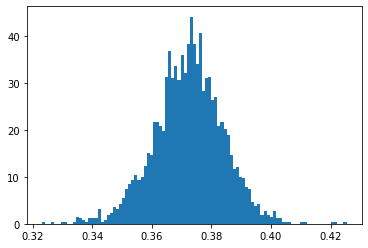

In [28]:
plt.hist(business_both_sims,bins=99,density=True)
plt.show()

### cluster review vectors

In [225]:
vecs_only = df[df.columns[8:-3]].to_numpy()

In [226]:
X = vecs_only
X = (X - np.min(X))/(np.max(X)-np.min(X)) # restrict to 0 to 1

In [236]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [233]:
%%time
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters,random_state=100)
kmeans.fit(X)
cluster_labels = kmeans.labels_

CPU times: total: 15min 2s
Wall time: 1min 22s


In [241]:
%%time
# reduce dimensions
num_components = 3
pca = PCA(n_components=num_components, random_state=100)
matrix_pca = pca.fit_transform(X)

CPU times: total: 16 s
Wall time: 3.32 s


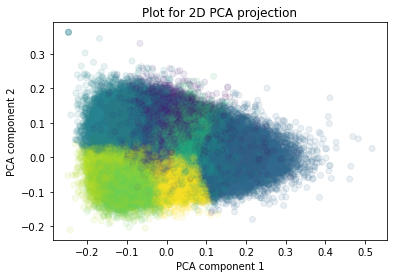

CPU times: total: 5.33 s
Wall time: 5.33 s


In [245]:
%%time
# 2D looks good
plt.scatter(matrix_pca[:,0],matrix_pca[:,2],
            alpha=0.1,c=cluster_labels,cmap='viridis')
plt.gca().set(title='Plot for 2D PCA projection', 
              xlabel='PCA component 1', ylabel='PCA component 2');
plt.show()